In [1]:
#Loading necessary packages
#pip install nltk==3.6.2 
import requests
import pandas as pd
import datetime
import time
import random
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from finvader import finvader

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Korisnik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Data
api_key = 'OTl2SM9_8xGEkqop_pj57cYyS4gjsurl'
news_url = "https://api.polygon.io/v2/reference/news"  

**Choose stock ticker & time span:**

In [3]:
#user input
ticker = input("Enter the stock ticker symbol (e.g., BA): ").strip().upper()
if not ticker:
    print("No ticker entered. Try again.")
    exit()

date_choice = input(
    "Choose the date range by typing in a corresponding number:\n"
    "1. Last day\n"
    "2. Last week\n"
    "3. Last month\n"
    "Enter your choice (1, 2, or 3): ").strip()

In [4]:
today = datetime.date.today()
if date_choice == "1":
    start_date = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
elif date_choice == "2":
    start_date = (today - datetime.timedelta(days=7)).strftime("%Y-%m-%d")
elif date_choice == "3":
    start_date = (today - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
else:
    print("Invalid choice. Defaulting to last month.")
    start_date = (today - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")
    
print(f"Start Date: {start_date}, End Date: {end_date}")

Start Date: 2025-01-05, End Date: 2025-01-12


In [5]:
def get_news(ticker, start_date, end_date, api_key, news_url, limit=100):
    """
    Fetch news for a ticker within a given date range.
    :param ticker: Stock ticker symbol.
    :param start_date: Start date (DD-MM-YYYY).
    :param end_date: End date (DD-MM-YYYY).
    :param limit: Number of articles to retrieve per request.
    :return: List of news articles.
    """
    params = {
        "ticker": ticker,
        "published_utc.gte": start_date,
        "published_utc.lte": end_date,
        "limit": limit,
        "apiKey": api_key
    }
    time.sleep(random.uniform(1, 3))  
    
    response = requests.get(news_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get("results", [])
    else:
        print(f"Failed to get news: {response.status_code} - {response.text}")
        return []

In [33]:
#def generate_weekly_intervals(start_date, end_date):
    """
    Generate weekly date intervals within the specified date range.
    :param start_date: Earliest date (DD-MM-YYYY).
    :param end_date: Latest date (DD-MM-YYYY).
    :return: List of (start_date, end_date) tuples for each week.
    """
    #intervals = []
    #current_end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    #current_start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    
    #while current_end_date > current_start_date:
     #   week_start_date = max(current_start_date, current_end_date - datetime.timedelta(days=6))
      #  intervals.append((week_start_date.strftime("%Y-%m-%d"), current_end_date.strftime("%Y-%m-%d")))
       # current_end_date -= datetime.timedelta(days=7)
    
   # return intervals

In [34]:
#fetch_intervals = generate_weekly_intervals(start_date, end_date)
#all_news = []

In [ ]:
for week_start, week_end in tqdm(fetch_intervals, desc="Fetching news"):
    try:
        weekly_news = get_news(ticker, week_start, week_end, api_key, news_url, limit=100)
        if not weekly_news:
            continue
        for article in weekly_news:
            article['ticker'] = ticker
        all_news.extend(weekly_news)
    except Exception as e:
        print(f"Error in accessing news for {ticker} from {week_start} to {week_end}: {e}")

In [6]:
def fetch_news(ticker, start_date, end_date, api_key, news_url):
    """Fetch news articles from the API."""
    params = {
        "ticker": ticker,
        "published_utc.gte": start_date,
        "published_utc.lte": end_date,
        "limit": 100,
        "apiKey": api_key
    }
    try:
        response = requests.get(news_url, params=params)
        if response.status_code == 200:
            return response.json().get("results", [])
        else:
            print(f"Error fetching news: {response.status_code}")
            return []
    except Exception as e:
        print(f"Error during request: {e}")
        return []

In [7]:
news = get_news(ticker, start_date, end_date, api_key, news_url)
if not news:
    print("No news found. Exiting.")
    exit()

In [8]:
news_df = pd.DataFrame(news)
if news_df.empty:
    print("No news found for the selected ticker and date range.")
    exit()

In [ ]:
news_df = pd.DataFrame(all_news)
if news_df.empty:
    print("No news found for the selected ticker and date range.")
    exit()

In [9]:
news_df['published_utc'] = pd.to_datetime(news_df['published_utc'], errors='coerce')
news_df['combined_text'] = news_df['title'] + " " + news_df['description'].fillna("")
news_df.dropna(subset=['published_utc'], inplace=True)

In [ ]:
news_df = news_df.drop(columns=['id', 'image_url', 'author', 'amp_url'], errors='ignore')
news_df['published_utc'] = pd.to_datetime(news_df['published_utc'], errors='coerce')
news_df = news_df.drop_duplicates(subset=['title', 'published_utc', 'ticker'])
news_df = news_df.dropna(subset=['published_utc'])  # Drop rows with invalid dates

**Sentiment Analysis** using combined title and description

In [10]:
#finVADER implementation
def sentiment_analysis(text):
    try:
        score = finvader(
            text,
            use_sentibignomics=True,  # Use SentiBignomics lexicon
            use_henry=True,          # Use Henry's lexicon
            indicator="compound"     # Compound sentiment score
        )
        return score
    except Exception as e:
        print(f"Error in FinVADER analysis: {e}")
        return None

In [38]:
#FinVADER sentiment analysis based on news article title 
#news_df['finvader_compound'] = news_df['title'].apply(sentiment_analysis)

In [11]:
#FinVADER sentiment analysis based on combination of article title & description

news_df['combined_text'] = news_df['title'] + " " + news_df['description'].fillna("")
news_df['combined_score'] = news_df['combined_text'].apply(sentiment_analysis)

In [12]:
def aggregate_sentiment(df):
    """Aggregating sentiment scores into daily, weekly and monthly for easier overview"""
    df['date'] = df['published_utc'].dt.date
    daily = df.groupby('date')['combined_score'].mean().reset_index().rename(columns={'combined_score': 'daily_sentiment'})
    df['week_start'] = df['published_utc'] - pd.to_timedelta(df['published_utc'].dt.dayofweek, unit='d')
    weekly = df.groupby('week_start')['combined_score'].mean().reset_index().rename(columns={'combined_score': 'weekly_sentiment'})
    df['month'] = df['published_utc'].dt.to_period('M')
    monthly = df.groupby('month')['combined_score'].mean().reset_index().rename(columns={'combined_score': 'monthly_sentiment'})
    return daily, weekly, monthly

daily_sentiment, weekly_sentiment, monthly_sentiment = aggregate_sentiment(news_df)

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_5628\3815784220.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_utc'].dt.to_period('M')


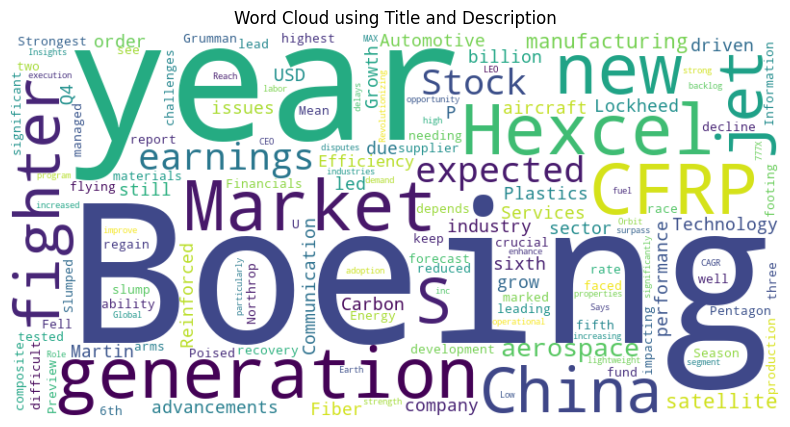

In [13]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(news_df['combined_text']))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud using Title and Description")
plt.show()

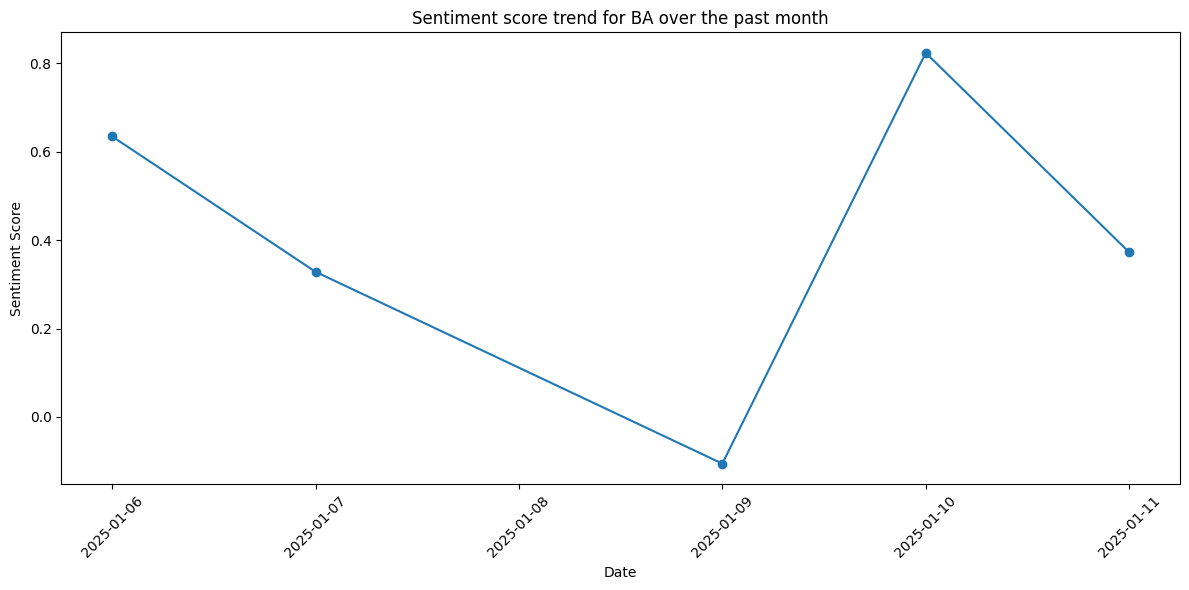

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment['date'], daily_sentiment['daily_sentiment'], marker='o', linestyle='-')
plt.title(f"Sentiment score trend for {ticker} over the past month")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

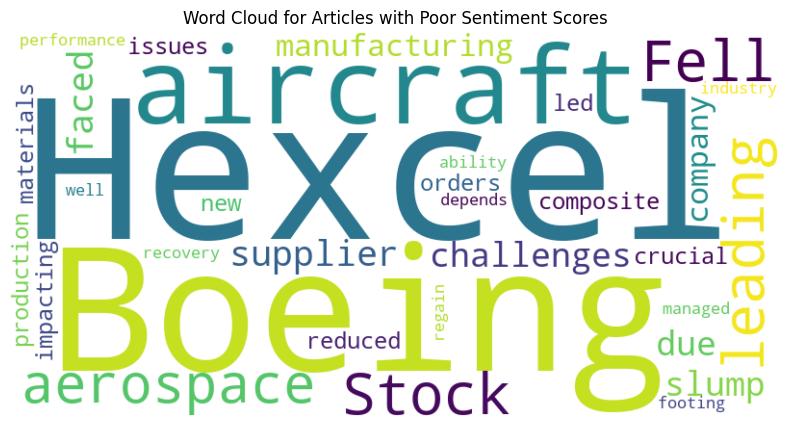

In [15]:
poor_sentiment_data = news_df[news_df['combined_score'] < 0]

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(poor_sentiment_data['combined_text'].dropna())
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Articles with Poor Sentiment Scores")
plt.show()

In [16]:
poor_sentiment_data

,id,publisher,title,author,published_utc,article_url,tickers,image_url,description,keywords,insights,amp_url,combined_text,combined_score,date,week_start,month
2,4eb3a22ce9545d6681a88706d0fb11242b10b89be8a552...,"{'name': 'The Motley Fool', 'homepage_url': 'h...",Why Hexcel Stock Fell in 2024,Lou Whiteman,2025-01-09 15:04:55+00:00,https://www.fool.com/investing/2025/01/09/why-...,"[HXL, BA, BApA]",https://g.foolcdn.com/editorial/images/803433/...,"Hexcel, a leading aerospace supplier, has face...","[Hexcel, Boeing, aerospace, composite material...","[{'ticker': 'HXL', 'sentiment': 'negative', 's...",NaN,"Why Hexcel Stock Fell in 2024 Hexcel, a leadin...",-0.3166,2025-01-09,2025-01-06 15:04:55+00:00,2025-01
